In [17]:
#应用RNN的简单神经网络
import torch
from torch.autograd import Variable
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [18]:
#超参数
EPOCH = 1 #训练整批数据集多少次
BATCH_SIZE = 64#将数据分成的单元的容量
TIME_STEP = 28 #rnn时间步数/图片高度 
"""时间步数就是rnn当前的状态往前关联的状态数量，
   本题的输入是将图片按行像素输入，所以也可理解为图片的高度
"""
IMPUT_SIZE = 28 #RNN每步的输入值/图片每行的像素
LR = 0.01 #LEARNING RATE
DOWNLOAD_MNIST = True #如果已经下载好了mnist数据就填False


In [19]:
#设定训练集
train_data = dsets.MNIST(
    root = '~/code/DATA/',#保存提取位置
    train = True, #这是一个训练集
    transform = transforms.ToTensor(),
    download = True
 ) 


torch.Size([60000, 28, 28])
torch.Size([60000])


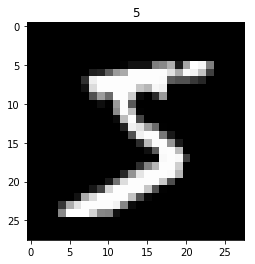

In [20]:
#打印一个范例
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(),cmap = 'gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [21]:
#读取器，用以自动迭代生成数据集
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)

In [22]:
#将测试集转换成Variable
test_data = dsets.MNIST(root = '~/code/DATA/', train = False, transform = transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255 #shape(2000,28,28) value in range（0，1）
test_y = test_data.test_labels.numpy().squeeze()[:2000]#variable数据类型至少有两维

In [23]:
#定义RNN
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        self.rnn = nn.LSTM(
            input_size = 28, #图片每行的像素点
            hidden_size = 64, #隐藏层的神经元数
            num_layers = 1, #rnn layers
            batch_first = True
        )
        
        self.out = nn.Linear(64,10)
        
    def forward(self,x):
         #x shape (batch, time_step, input_size)
        #r_out shape (batch, time_step, output_size)
        #h_n shape (n_layers, batch, hidden_size)
        #h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None) #None 表示hidden state 会用全0的state
        
        #choose r_out at the last time step
        out = self.out(r_out[:,-1.:])
        return out

In [24]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [25]:
optimizer = torch.optim.Adam(rnn.parameters(), lr = LR)
loss_func = torch.nn.CrossEntropyLoss() #交叉熵损失函数，效果好过均方差损失函数

#根据网上文档，numpy v1.12.0 doesn't support float indices，但是rnn又要求b_x的类型时float的类型，如果强制类型转换就会报错类型不匹配。

In [32]:
for epoch in range(EPOCH):
    for step,(b_x,b_y) in enumerate(train_loader):
        b_x = b_x.view(-1, 28, 28)
        b_x = b_x.type(torch.IntTensor)
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0 :
            test_output = rnn(test_x)
            pred_y = torch.max(test_outpu,1)[1].data.numpy().squeeze()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch:', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


RuntimeError: Expected object of type torch.FloatTensor but found type torch.IntTensor for argument #4 'mat1'

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
#print 10 predicions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output,1)[1].data.numpy().squeeze()
print(pred_y,'predicion number')
print(test_y[:10],'real number')